In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import ast
import warnings

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *
from ModelSelection import *


%matplotlib inline

In [2]:
tr_norm_df = pd.read_csv('../data/divided_std_train_0_8.csv')
test_norm_df = pd.read_csv('../data/divided_std_test_0_2.csv')

tr_df = pd.read_csv('../data/divided_train_0_8.csv')
test_df = pd.read_csv('../data/divided_test_0_2.csv')

ML_cup_train = pd.read_csv('../data/ML-CUP23-TR.csv', header=None, index_col=0, comment='#')

TR_INPUT = 10
TR_OUTPUT = 3

tr_normalized = tr_norm_df.values
test_normalized = test_norm_df.values
training_set = tr_df.values
test_set = test_df.values

scaler_out = StandardScaler()
scaler_out.fit(ML_cup_train.values[:,TR_INPUT:])

training_len = len(tr_norm_df)
test_len = len(test_norm_df)

In [3]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

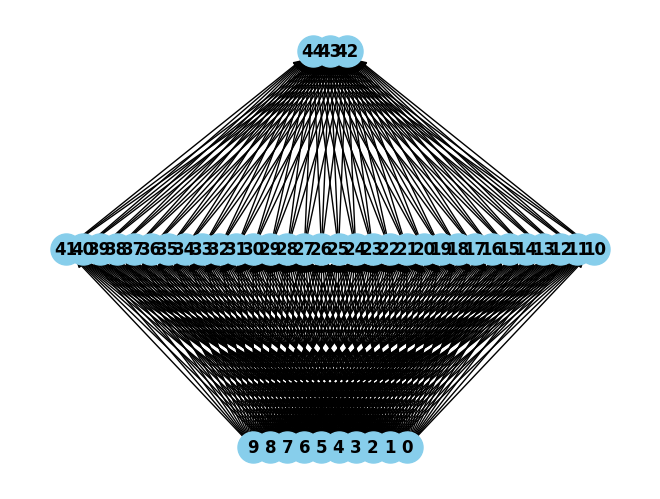

In [4]:
hidden_len = 32
hidden_fun = 'sigmoid'
output_fun = 'identity'
sigmoid_l1 = create_stratified_topology([TR_INPUT,hidden_len,TR_OUTPUT], 
                                      [[None,[]]]*TR_INPUT + [[hidden_fun, [1]]]*hidden_len + [[output_fun, []]]*TR_OUTPUT)
NeuralNetwork.display_topology(sigmoid_l1)

In [5]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

In [6]:
def remove_useless_val(x):
    a =['learning_rate', 'lr_decay_tau', 'alpha_momentum']
    b =['adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2']
    if x['adamax']:
        for i in a:
            if i in x.keys():
                x[i] = None
    else:
        for i in b:
            if i in x.keys():
                x[i] = None   
    return x

In [7]:
columns_order = ['topology', 'stats',
 'batch_size',
 'min_epochs',
 'max_epochs',
 'patience',
 'error_increase_tolerance',
 'lambda_tikhonov',
 
 'learning_rate',
 'alpha_momentum',
 'lr_decay_tau',
 
 'adamax',
 'adamax_learning_rate',
 'exp_decay_rate_1',
 'exp_decay_rate_2',
 
 'mean_mean_euclidean_error',
 'mean_mean_squared_error',
 'var_mean_euclidean_error',
 'var_mean_squared_error',
 'mean_best_validation_training_error']

In [8]:
results_files = ['bagging_model.csv']
topologies = ['32_sigmoid']
folder = '../data/gs_data/'
topologies_dict = {}
gs_results = []
for i, f in enumerate(results_files):
    if os.path.isfile(folder+ f):
        dummy = pd.read_csv(folder + f)
        topologies_dict[topologies[i]] = ast.literal_eval(dummy['topology'][0])
        dummy['topology'] = topologies[i]
        
        gs_results.append(dummy)
    


orig_df = pd.concat(gs_results)

In [9]:
columns_order = [x for x in columns_order if x in orig_df.columns]
orig_df = orig_df[columns_order]

order_by = 'mean_mean_euclidean_error'
orig_df.sort_values(by=[order_by], inplace=True)
orig_df = orig_df.reset_index(drop=True)
gs_results = orig_df.drop(['stats'], axis=1)

In [10]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
gs_results = gs_results.apply(remove_useless_val, axis=1)
#warnings.simplefilter(action='default', category=FutureWarning)
for i in gs_results.columns[1:]:
    gs_results[i] = gs_results[i].astype(float)

In [11]:
numerical_col = list(gs_results.columns)
numerical_col.remove('topology')
st_opt_col = ['learning_rate','lr_decay_tau','alpha_momentum']
adamax_opt_col = ['adamax','adamax_learning_rate','exp_decay_rate_1','exp_decay_rate_2']
metrics_col = [x for x in gs_results.columns if x.startswith(('var', 'mean'))]
general_col = [item for item in list(gs_results.columns) if item not in st_opt_col and item not in metrics_col and item not in adamax_opt_col]
tr_input_col = [item for item in list(gs_results.columns) if item not in metrics_col]

In [12]:
orig_df

,topology,stats,batch_size,min_epochs,max_epochs,patience,error_increase_tolerance,lambda_tikhonov,learning_rate,alpha_momentum,lr_decay_tau,adamax,mean_mean_euclidean_error,mean_mean_squared_error,var_mean_euclidean_error,var_mean_squared_error,mean_best_validation_training_error
0,32_sigmoid,"{'adamax': False, 'exp_decay_rate_2': 0.999, '...",8,150,500,5,0.000001,1.000000e-09,0.11,0.85,200,False,0.098424,0.013096,0.000005,5.119440e-07,0.009886


In [13]:
gen = np.random.default_rng(seed=None)
def get_new_tr_vl(pattern_set, len_ds, gen):
    return gen.choice(pattern_set, len_ds)

In [14]:
n_models = 2
tr_len = 533
max_epochs = 5
mod = []

met = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error, ]
predictions_accumul_tr = []
predictions_accumul_val = []
predictions_accumul_tr = [np.zeros((max_epochs, training_len, TR_OUTPUT))]*2
predictions_accumul_val = [np.zeros((max_epochs, test_len, TR_OUTPUT))]*2

index = 5
for i in range(index, index + n_models):
    
    tr = get_new_tr_vl(tr_normalized, 533, gen)
    NN = NeuralNetwork(sigmoid_l1, -0.75, 0.75, True, (i + 999989999))
    stats = NN.train(training_set =tr, 
                    validation_set = test_normalized, 
                    
                    batch_size= 8, 
                    max_epochs= max_epochs, 
                    min_epochs= 150,
                    retrainig_es_error = orig_df.iloc[0]['mean_best_validation_training_error'],
                    patience = 5, 
                    error_increase_tolerance = 0.000001, 
                    
                    lambda_tikhonov = 1.000000e-09, # off
                    
                    adamax = False,
                    
                    learning_rate = 0.11/8,
                    lr_decay_tau = 200, # off
                    eta_tau= (0.11/8)*0.01,
                    alpha_momentum = 0.85, # off
                    nesterov = False,
                    
                    metrics = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error, ], 
                    collect_data=True, 
                    collect_data_batch=False, 
                    verbose=True,
                    
                    dataset_agg = tr_normalized)
    
    for j, mes in enumerate(met):
        
        predictions_accumul_tr[j] += np.array(stats['training_pred_' + mes.__name__] + 
                                              [stats['training_pred_' + mes.__name__][-1]]*(max_epochs - stats['epochs']))
        del stats['training_pred_' + mes.__name__]
        
        predictions_accumul_val[j] += np.array(stats['validation_pred_' + mes.__name__] + 
                                              [stats['validation_pred_' + mes.__name__][-1]]*(max_epochs - stats['epochs']))
        del stats['validation_pred_' + mes.__name__]
    
    
    mod.append([NN, stats, tr])
    with open('../data/net/models_6_ens/model_' + str(i) + '.json', 'w+') as file:
            file.write(NN.toJSON())

for i in range(len(met)):
    predictions_accumul_tr[i] /= n_models
    predictions_accumul_val[i] /= n_models

starting values:  {'training_set_len': 533, 'minibatch_size': 8, 'max_epochs': 500, 'retrainig_es_error': 0.01087478308764089, 'error_increase_tolerance': 1e-06, 'patience': 5, 'min_epochs': 150, 'learning_rate': 0.01375, 'lr_decay_tau': 200, 'eta_tau': 0.0001375, 'lambda_tikhonov': 1e-09, 'alpha_momentum': 0.85, 'nesterov': False, 'adamax': False, 'adamax_learning_rate': 0.01, 'exp_decay_rate_1': 0.9, 'exp_decay_rate_2': 0.999, 'best_validation_training_error': inf, 'epochs': 0, 'total_train_time': datetime.timedelta(days=-1, seconds=86399, microseconds=999996), 'mean_epoch_train_time': 0, 'units_weights': {41: [], 40: [], 39: [], 38: [], 37: [], 36: [], 35: [], 34: [], 33: [], 32: [], 31: [], 30: [], 29: [], 28: [], 27: [], 26: [], 25: [], 24: [], 23: [], 22: [], 21: [], 20: [], 19: [], 18: [], 17: [], 16: [], 15: [], 14: [], 13: [], 12: [], 11: [], 10: [], 44: [], 43: [], 42: []}, 'units_weights_batch': {}, 'training_mean_squared_error': [], 'validation_mean_squared_error': [], 'tra

[1/500] tr time: 0:00:01.246930 | mean_squared_error: tr=0.13875410455796047 val=0.14085050499549154 | | mean_euclidean_error: tr=0.33520885000182893 val=0.3381622738458623 | 
[2/500] tr time: 0:00:01.224771 | mean_squared_error: tr=0.07712639717922147 val=0.08515512976664862 | | mean_euclidean_error: tr=0.24299141524923312 val=0.25839354132018555 | 
[3/500] tr time: 0:00:01.210607 | mean_squared_error: tr=0.06783578454102822 val=0.07379775127359486 | | mean_euclidean_error: tr=0.2317675512241635 val=0.23706721638022762 | 
[4/500] tr time: 0:00:01.764496 | mean_squared_error: tr=0.052695337927339526 val=0.06646032312983903 | | mean_euclidean_error: tr=0.20131418574528417 val=0.2244296563455576 | 
[5/500] tr time: 0:00:01.356398 | mean_squared_error: tr=0.05797988163445064 val=0.06730287394344611 | | mean_euclidean_error: tr=0.21775934025585442 val=0.23650373672118719 | 
[6/500] tr time: 0:00:01.112096 | mean_squared_error: tr=0.06243793879158267 val=0.06916603483892242 | | mean_euclide

In [15]:
def construct_obj(list_mod):
    interesting_model = []
    for i in range(len(list_mod)):
        
        dummy = {}
        dummy['nn_file_name'] = '../data/net/models_6_ens_retr_giacomo/model_' + str(i) + '.json'
        dummy['index'] = i
        dummy['model'] = list_mod[i][0]
        dummy['stats'] = list_mod[i][1]
        dummy['top_name'] = '32_sigmoid'
        
        dummy['std_prediction_tr'] = dummy['model'].predict_array(list_mod[i][2][:,:TR_INPUT])
        dummy['std_prediction_test'] = dummy['model'].predict_array(test_normalized[:,:TR_INPUT])
        
        dummy['prediction_tr'] = scaler_out.inverse_transform(dummy['std_prediction_tr'])
        dummy['prediction_test'] = scaler_out.inverse_transform(dummy['std_prediction_test'])

        dummy['std_tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_tr'], list_mod[i][2][:,TR_INPUT:])
        dummy['std_test_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_test'], test_normalized[:,TR_INPUT:])
             
        dummy['tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_tr'], scaler_out.inverse_transform(list_mod[i][2][:,TR_INPUT:]))
        dummy['test_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_test'], test_set[:,TR_INPUT:])
        interesting_model.append(dummy)
        
    return interesting_model

In [16]:
models_list = construct_obj(mod)

In [17]:
with open('../data/net/models_6_ens_retr_giacomo/models.json', 'w+') as file:
    save_obj(models_list, file)

In [18]:
with open('../data/net/models_6_ens_retr_giacomo/ens_curves_tr.json', 'w+') as file:
    file.write(json.dumps(np.array(predictions_accumul_tr).tolist()))
with open('../data/net/models_6_ens_retr_giacomo/ens_curves_test.json', 'w+') as file:
    file.write(json.dumps(np.array(predictions_accumul_val).tolist()))